### Time to get your hands dirty.  The transient Universe


Let's go back to our previous example on the astrophysical transient.


8) Fit the same model from before with the same priors,  but this time use nested sampling.

    $y = b$, for $t<t_0$

    $y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors (I used `ppf` from `scipy.stats.uniform`, but there are other ways to do it)

An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did earlier.



In [56]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats
import dynesty
import corner
from dynesty import utils as dyfunc
from dynesty import plotting as dyplot

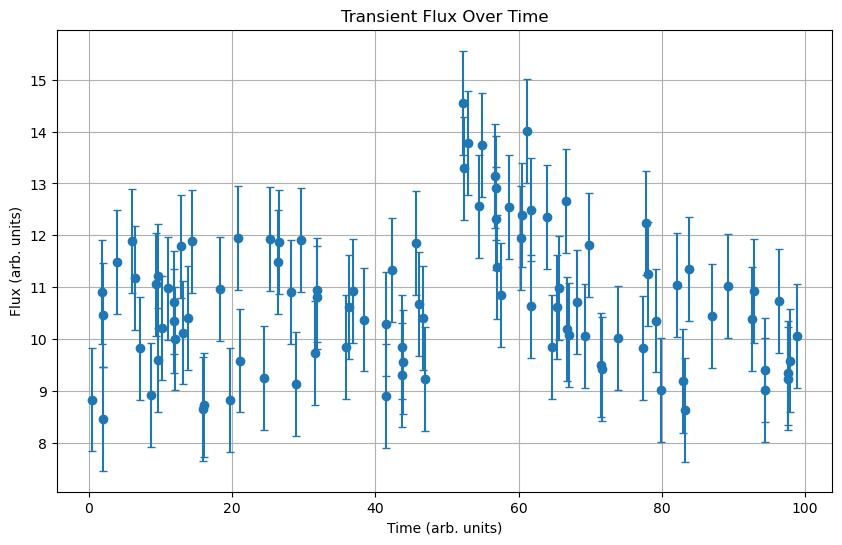

In [57]:
# Load the data
data = np.load('../solutions/transient.npy')  # Shape: (100, 3)

# Extract columns
t,y,yerr=data.T

# Plot
plt.figure(figsize=(10, 6))
plt.errorbar(t, y, yerr=yerr, fmt='o', capsize=3, label='Flux with uncertainty')
plt.xlabel('Time (arb. units)')
plt.ylabel('Flux (arb. units)')
plt.title('Transient Flux Over Time')
plt.grid(True)

In [58]:
def burst_model (theta, t):
    A,b,t_0,alpha=theta
    return np.where(t < t_0, b, b + A * np.exp(-alpha * (t - t_0))) # np.where bc t is an array

Try to fit to check

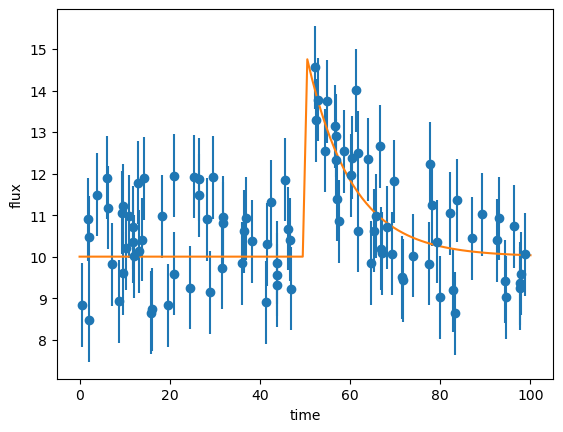

In [59]:
tgrid=np.linspace(0,100,100)
t0_quick=50
A_quick=5
b_quick=10
alpha_quick=0.1


theta_quick= np.array([A_quick, b_quick, t0_quick, alpha_quick])
ygrid =  burst_model(theta_quick, tgrid)

plt.errorbar(t,y,yerr=yerr,fmt='o')
plt.xlabel("time")
plt.ylabel("flux")
plt.plot(tgrid,ygrid);

In [60]:
t0min,t0max = 0,100
Amin,Amax=0,50
bmin,bmax=0,50
alphamin,alphamax=np.exp(-5),np.exp(5)

ndim = 4

In [61]:
def LogLikelihood(theta, data, model): # burst_model, uncertainty(of flux), data
    x, y, yerr = data.T
    # Gaussian likelihood: I'm not tracking the normalization here! 
    # Ok because here I only care about the ratio between two evidences, not the evidence itself
    y_fit = model(theta, x)
    return 0.5*np.sum(-(y - y_fit)**2 /yerr**2)

# Function that takes in samples from the unit cube (u ∈ [0,1]^ndim) and returns samples from your prior distribution
def ptform(u): 
    """Transforms the uniform random variables `u ~ Unif[0., 1.)`
    to the parameters of interest."""

    x = np.array(u)  # copy u

    # .ppf (Percent-Point Function) return the inverse CDF: given a probability p (e.g u=0.2), return the value x such that P(X ≤ x) = p (e.g. x=2 in range [0, 10])
    x[0] = scipy.stats.uniform(loc=Amin,scale=Amax-Amin).ppf(u[0]) 
    x[1] = scipy.stats.uniform(loc=bmin,scale=bmax-bmin).ppf(u[1])
    x[2] = scipy.stats.uniform(loc=t0min,scale=t0max-t0min).ppf(u[2])
    x[3] = scipy.stats.loguniform.ppf(u[3],alphamin,alphamax)
   
    return x


Nested sampling

In [62]:
# "Static" nested sampling.
sampler = dynesty.NestedSampler(LogLikelihood, ptform, ndim, logl_args=[data, burst_model], nlive=300) # nlive is the number of live points the sampler uses to explore the parameter space
sampler.run_nested()
sresults = sampler.results

C:\Users\simon\AppData\Local\Temp\ipykernel_17472\4078049396.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t < t_0, b, b + A * np.exp(-alpha * (t - t_0))) # np.where bc t is an array
C:\Users\simon\AppData\Local\Temp\ipykernel_17472\4078049396.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t < t_0, b, b + A * np.exp(-alpha * (t - t_0))) # np.where bc t is an array
1065it [00:44,  2.89it/s, bound: 0 | nc: 156 | ncall: 10784 | eff(%):  9.876 | loglstar:   -inf < -190.641 <    inf | logz: -198.999 +/-  0.157 | dlogz: 115.850 >  0.309]  C:\Users\simon\AppData\Local\Temp\ipykernel_17472\4078049396.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t < t_0, b, b + A * np.exp(-alpha * (t - t_0))) # np.where bc t is an array
1077it [00:45, 12.89it/s, bound: 1 | nc: 7 | ncall: 10866 | eff(%):  9.912 | loglstar:   -inf < -184.453 <    inf | logz: -193.597 +/-  0.160 | dlogz: 110.738 >  0.309]  C:\Users\simon\AppData\Local\Temp\ipyk

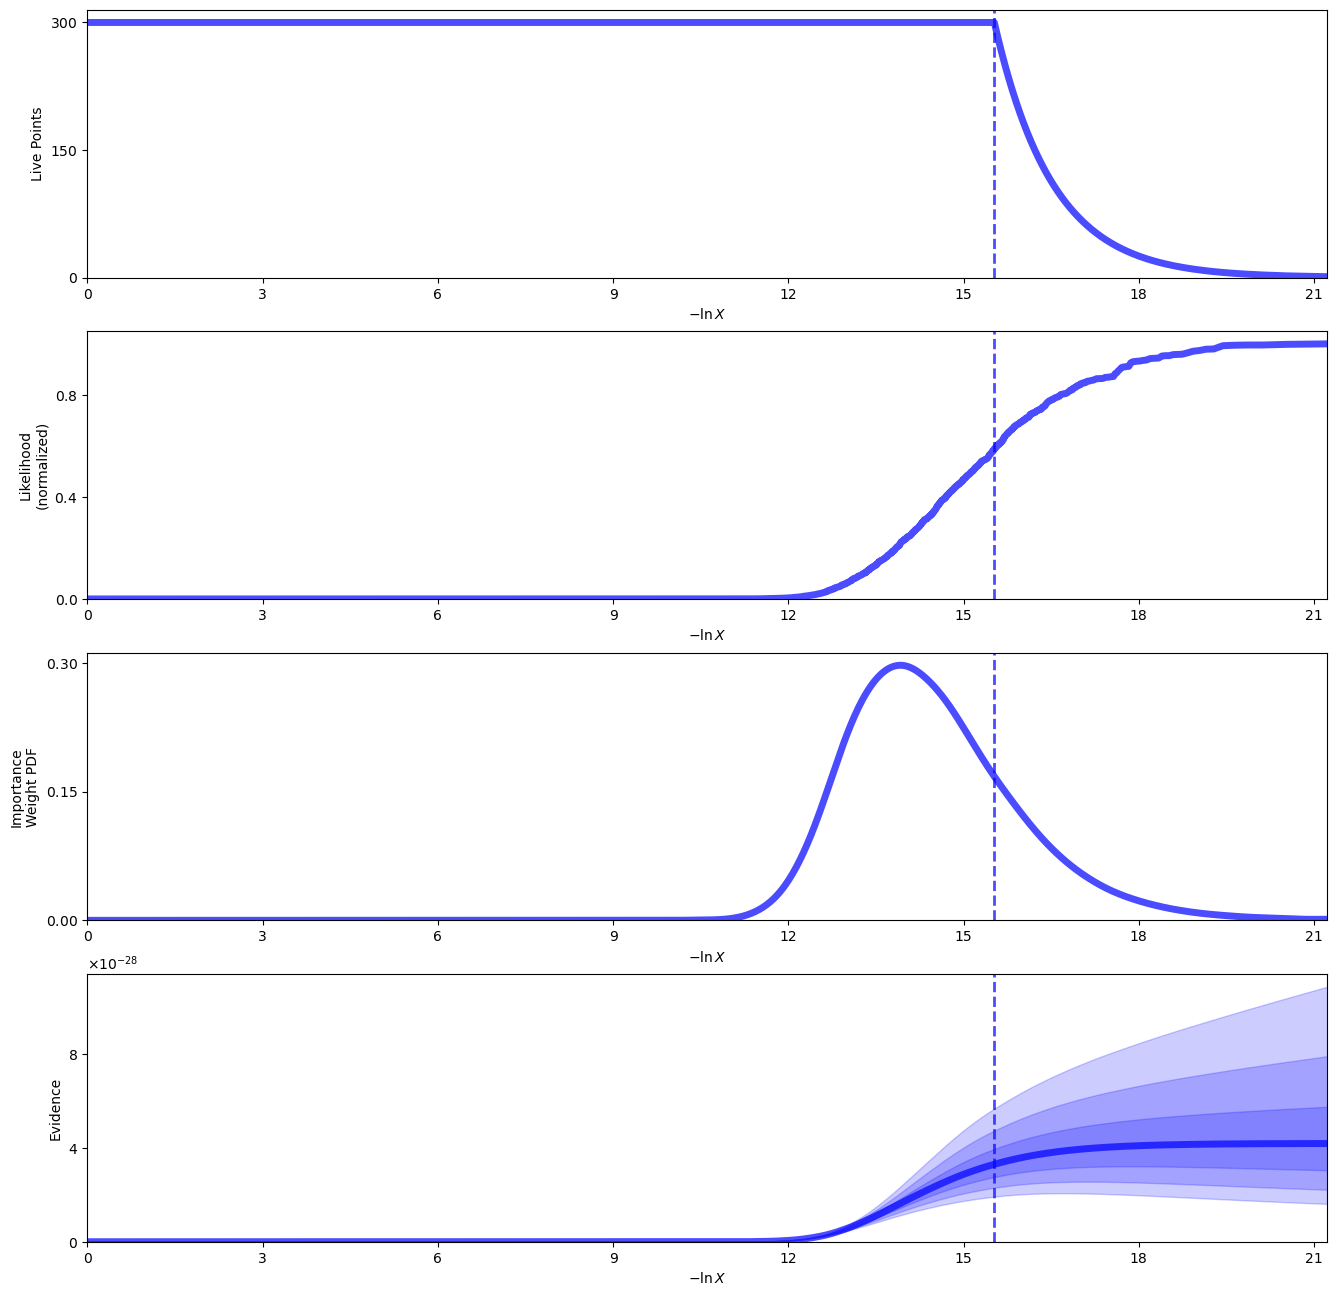

In [63]:
# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults)

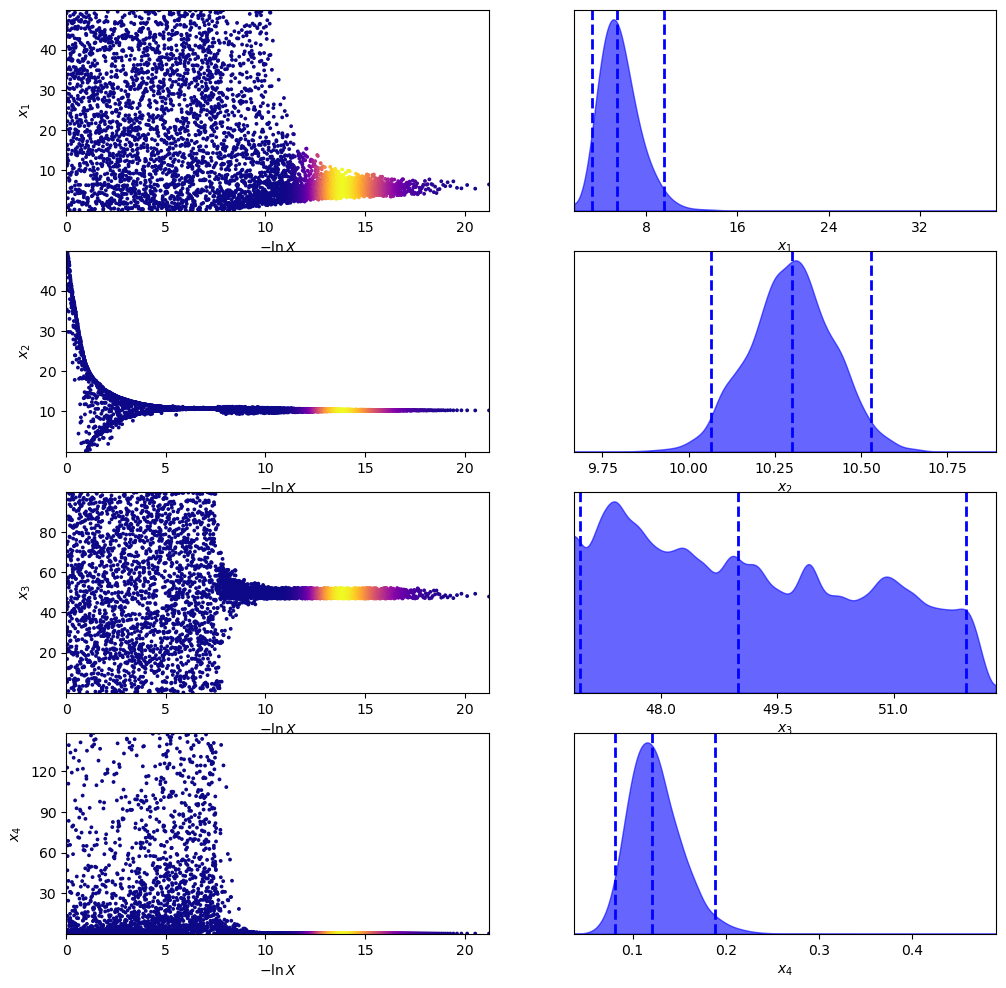

In [64]:
tfig, taxes = dyplot.traceplot(sresults)

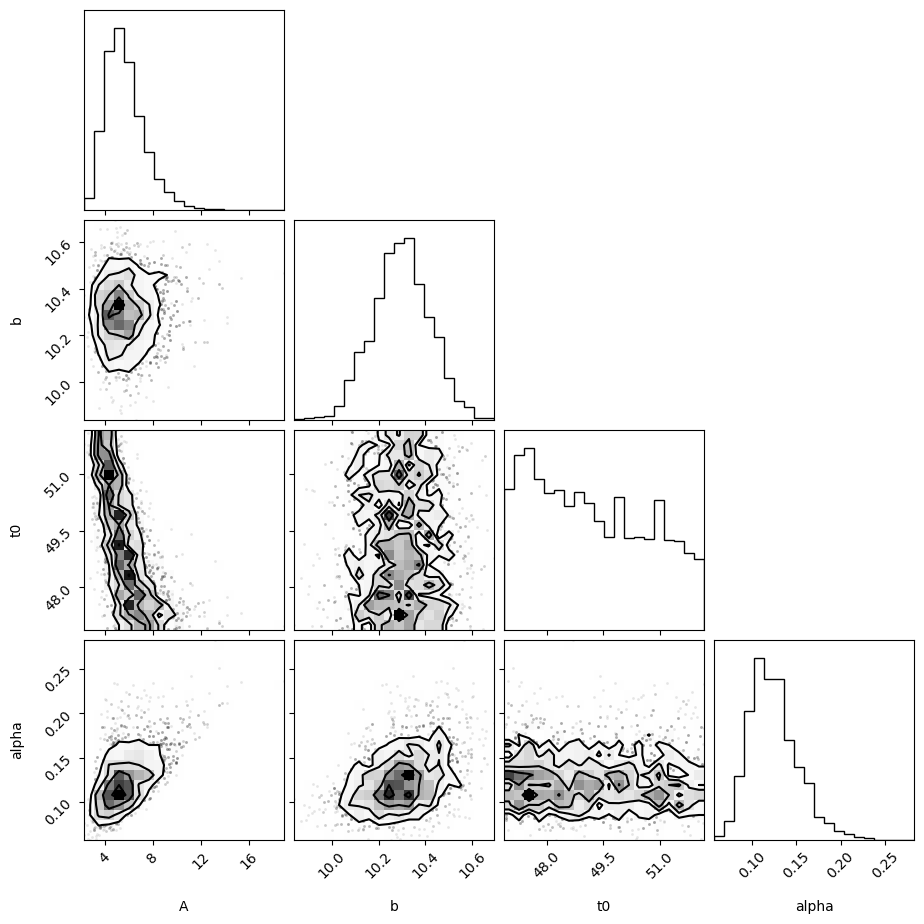

In [65]:
# **Very important** Samples that come out of a nested sampling runs are **weighted**
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights

labels = ["A","b","t0","alpha"]

samples_equal = dyfunc.resample_equal(samples, weights)
corner.corner(samples_equal,labels=labels);

In [66]:
print("\t Median \t Low-level \t\t Up-level of 90% credible region")

quantiles = [dyfunc.quantile(samps, [0.05, 0.5, 0.95], weights=weights)
             for samps in samples.T]
for q,l in zip(quantiles,labels):
    low,med,up=q
    print(l+"   "+str(med)+" +"+str(up-med)+" -"+str(med-low))

	 Median 	 Low-level 		 Up-level of 90% credible region
A   5.461086010793401 +3.4022959107011426 -1.9446646737737923
b   10.299213451983372 +0.1968646167575372 -0.204918501964249
t0   48.98910923130846 +2.7646513471676286 -1.907169709173452
alpha   0.12133176043977503 +0.05237832910475104 -0.03487478667940269


In [67]:
sresults.summary()

Summary
nlive: 300
niter: 4665
ncall: 70742
eff(%):  7.018
logz: -63.040 +/-  0.318


7) Another possible model that may explain the data is a Gaussian profile described by:

    $y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

    Fit this model usign nested sampling and reasonable priors (this time is up to you to decide...)


In [68]:
def gprofile_model (theta, t):
    A,b,t_0,sigmaW=theta
    return b + A*np.exp(-(t-t_0)**2 / 2*sigmaW**2)

Fit check to choose prior...i play with sigmaW

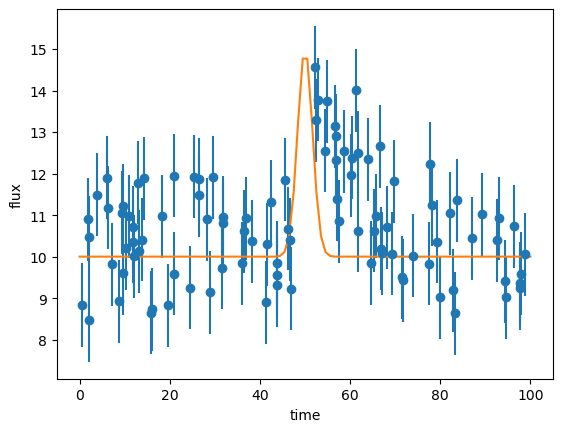

In [111]:
tgrid=np.linspace(0,100,100)
sigmaW_quick= np.exp(-0.5)


theta_quick= np.array([A_quick,b_quick,t0_quick,sigmaW_quick])
ygrid =  gprofile_model(theta_quick,tgrid)

plt.errorbar(t,y,yerr=yerr,fmt='o')
plt.xlabel("time")
plt.ylabel("flux")
plt.plot(tgrid,ygrid)

In [125]:
sigmaWmin, sigmaWmax = np.exp(-2), np.exp(2) # I choose the prior

In [126]:
# Function that takes in samples from the unit cube (u ∈ [0,1]^ndim) and returns samples from your prior distribution
def ptform_gprofile(u): 
    """Transforms the uniform random variables `u ~ Unif[0., 1.)`
    to the parameters of interest."""

    x = np.array(u)  # copy u

    # .ppf (Percent-Point Function) return the inverse CDF: given a probability p (e.g u=0.2), return the value x such that P(X ≤ x) = p (e.g. x=2 in range [0, 10])
    x[0] = scipy.stats.uniform(loc=Amin,scale=Amax-Amin).ppf(u[0]) 
    x[1] = scipy.stats.uniform(loc=bmin,scale=bmax-bmin).ppf(u[1])
    x[2] = scipy.stats.uniform(loc=t0min,scale=t0max-t0min).ppf(u[2])
    x[3] = scipy.stats.loguniform.ppf(u[3],sigmaWmin,sigmaWmax)
   
    return x

In [127]:
# "Static" nested sampling.
sampler = dynesty.NestedSampler(LogLikelihood, ptform_gprofile, ndim, logl_args=[data, gprofile_model], nlive=300) # nlive is the number of live points the sampler uses to explore the parameter space
sampler.run_nested()
sresults_gprofile = sampler.results

2363it [05:15,  1.11s/it, bound: 84 | nc: 37 | ncall: 47535 | eff(%):  4.971 | loglstar:   -inf < -86.584 <    inf | logz: -94.154 +/-  0.147 | dlogz: 28.947 >  0.309]     c:\Users\simon\anaconda3\Lib\site-packages\dynesty\bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
c:\Users\simon\anaconda3\Lib\site-packages\dynesty\bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or dif

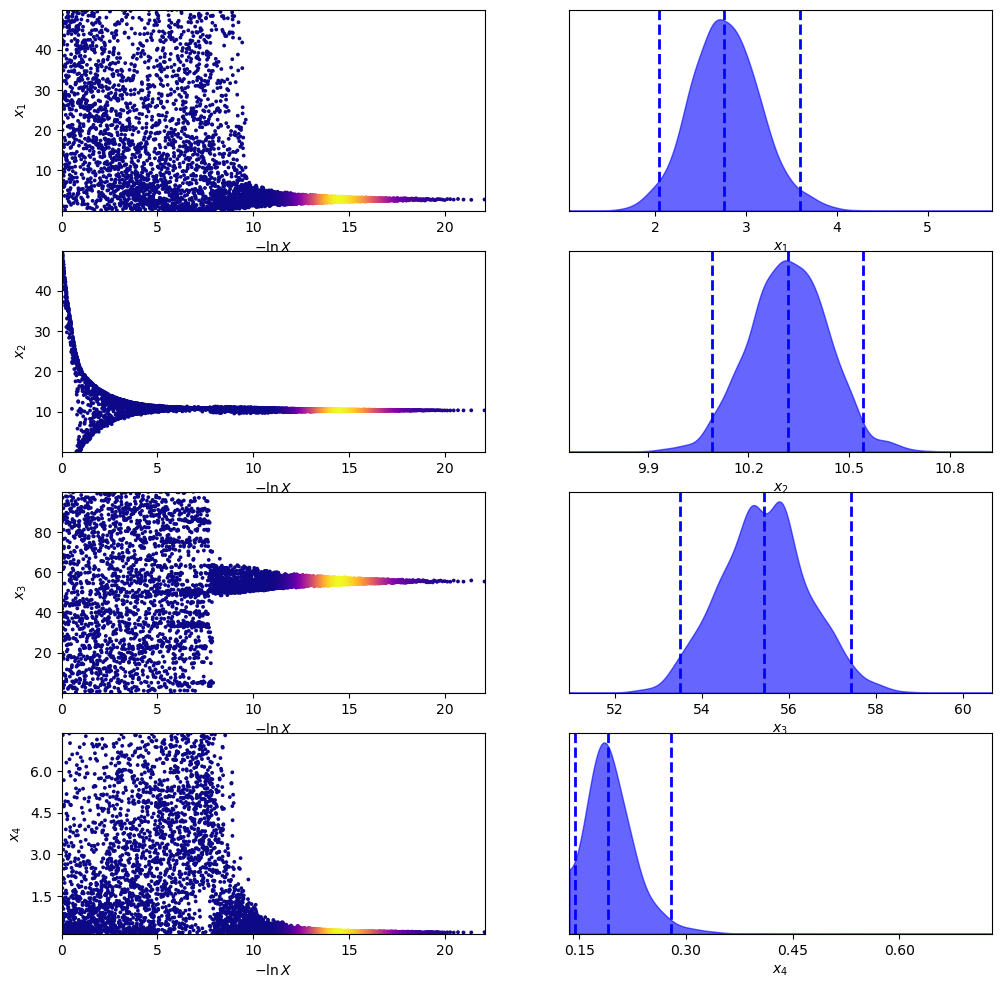

In [128]:
tfig, taxes = dyplot.traceplot(sresults_gprofile)

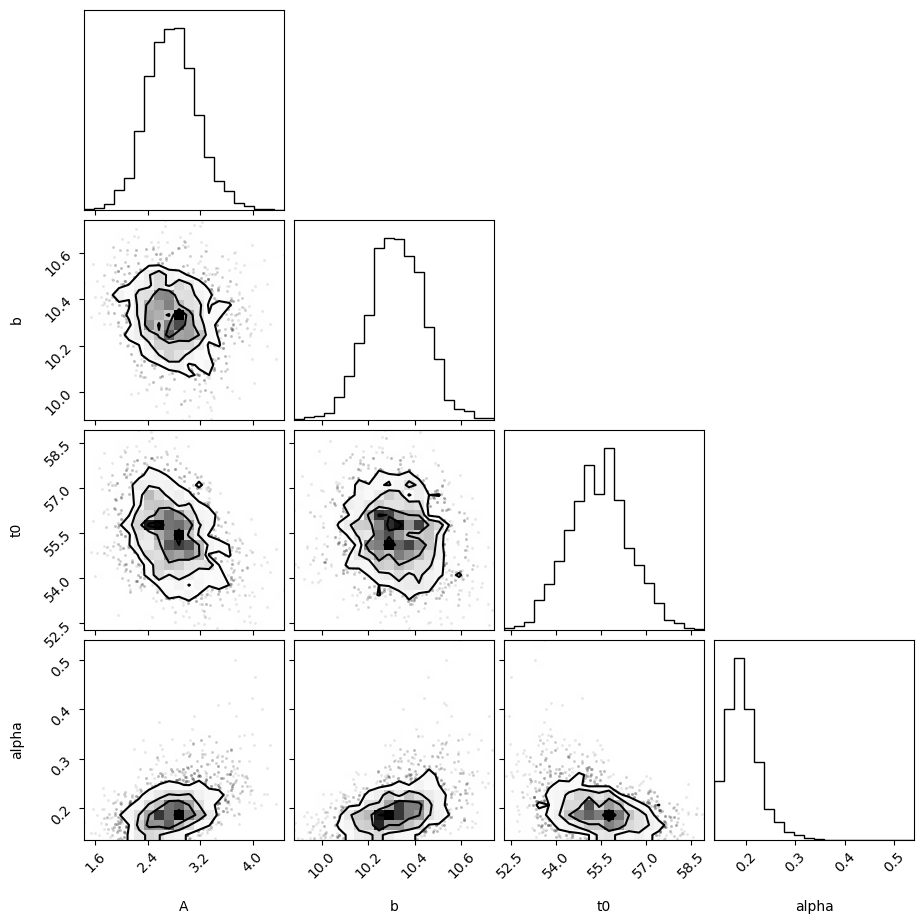

In [129]:
# **Very important** Samples that come out of a nested sampling runs are **weighted**
samples = sresults_gprofile.samples  # samples
weights = np.exp(sresults_gprofile.logwt - sresults_gprofile.logz[-1])  # normalized weights

labels = ["A","b","t0","alpha"]

samples_equal = dyfunc.resample_equal(samples, weights)
corner.corner(samples_equal,labels=labels);

In [130]:
sresults_gprofile.summary()

Summary
nlive: 300
niter: 4923
ncall: 81640
eff(%):  6.398
logz: -67.622 +/-  0.323


Decisive evidence in favour of burst model


9) Unlike MCMCs, nested sampling provides the Bayesian evidence. Compute the Bayesian evidence for this Gaussian model, and for the original burst model. Which model is the favored description of the data? Express this in terms of the Jeffrey's scale.

In [131]:
print( "Bayes Factor = ", np.exp(sresults.logz[-1])/np.exp(sresults_gprofile.logz[-1])) # logz is the log of the marginal likelihood (a.k.a. Bayesian evidence)

Bayes Factor =  97.71811865110267
